In [1]:
import sys, os
import numpy as np
import argparse

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

from utils import default_paths, nsd_utils
from feature_extraction import default_feature_loaders
from model_fitting import initialize_fitting 

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"


In [5]:
thing = '/user_data/mmhender/features/gabor_texture/simulated_data/S1_sim_data_addnoise_0.10.npy'
out = np.load(thing, allow_pickle=True).item()



TypeError: item() takes no keyword arguments

In [4]:
out['simulated_voxel_prf_inds']

array([  16,   16,   16, ..., 1262, 1262, 1262])

In [2]:
from analyze_fits import make_simulated_data
for noise_mult in [0,0.20]:
    make_simulated_data.make_sim_data(noise_mult=noise_mult)

making feature loader with image set: S1
Loading pre-computed features for models [0 - 99] from /user_data/mmhender/features/gabor_texture/S1_features_each_prf_12ori_8sf_gabor_solo_nonlin_grid5.h5py
Took 1.97311 seconds to load file
Size of features array for this image set and batch is:
(10000, 96, 100)
Index into batch for prf 16: 16
Final size of feature matrix for this image set and pRF is:
(10000, 96)
Index into batch for prf 18: 18
Final size of feature matrix for this image set and pRF is:
(10000, 96)
Index into batch for prf 20: 20
Final size of feature matrix for this image set and pRF is:
(10000, 96)
Index into batch for prf 22: 22
Final size of feature matrix for this image set and pRF is:
(10000, 96)
Index into batch for prf 24: 24
Final size of feature matrix for this image set and pRF is:
(10000, 96)
Index into batch for prf 26: 26
Final size of feature matrix for this image set and pRF is:
(10000, 96)
Index into batch for prf 28: 28
Final size of feature matrix for this 

In [2]:
subject=1
feature_type='gabor_solo'
trial_subset='animate_only'
which_prf_grid=5
debug=False
layer_name=None


In [3]:
models = initialize_fitting.get_prf_models(which_grid = which_prf_grid)    

folder = os.path.join(default_paths.stim_labels_root,'resampled_trial_orders')
if 'only' in trial_subset:        
    axis = trial_subset.split('_only')[0]
    fn2load = os.path.join(folder,
               'S%d_trial_resamp_order_has_%s.npy'%\
                       (subject, axis))        
elif 'balance' in trial_subset:        
    axis = trial_subset.split('balance_')[1]
    fn2load = os.path.join(folder, \
               'S%d_trial_resamp_order_both_%s.npy'%\
                       (subject, axis)) 

print('loading balanced trial order (pre-computed) from %s'%fn2load)
trials = np.load(fn2load, allow_pickle=True).item()

index = 0;
# masks of which trials to use in each data partition (trn/val/out), 
# for each pRF
trn_trials_use = trials['trial_inds_trn'][:,index,:]
val_trials_use = trials['trial_inds_val'][:,index,:]
out_trials_use = trials['trial_inds_out'][:,index,:]

image_inds_trn = trials['image_order'][trials['trninds']]
image_inds_val = trials['image_order'][trials['valinds']]
image_inds_out = trials['image_order'][trials['outinds']]

n_partitions = 3 # trn, val, out
partition_inds = [image_inds_trn, image_inds_val, image_inds_out]
partition_inds_use = [trn_trials_use, val_trials_use, out_trials_use]

# create feature loaders
feat_loaders, path_to_load = \
    default_feature_loaders.get_feature_loaders([subject], feature_type, which_prf_grid)
feat_loader = feat_loaders[0]



loading balanced trial order (pre-computed) from /user_data/mmhender/nsd/labels/resampled_trial_orders/S1_trial_resamp_order_has_animate.npy
making feature loader with image set: S1


In [92]:
from utils import prf_utils
from model_fitting import initialize_fitting

models = initialize_fitting.get_prf_models(which_grid = which_prf_grid)
angle_deg, eccen_deg = prf_utils.cart_to_pol(models[:,0]*8.4, models[:,1]*8.4)
ecc_use = np.unique(eccen_deg.round(2))[1:-2:2]
ang_use = np.unique(angle_deg.round(2))[0::2]
size_use = np.unique(models[:,2].round(2))[0::2]

n_prfs_total = models.shape[0]
inds_use = np.zeros((n_prfs_total,),dtype=bool)

egrid, agrid, sgrid = np.meshgrid(ecc_use, ang_use, size_use)
for e,a,s in zip(egrid.ravel(), agrid.ravel(), sgrid.ravel()):
    x,y = prf_utils.pol_to_cart(a,e)
    x/=8.4; y/=8.4;
    dist = np.sum(np.abs(models-[x,y,s]), axis=1)
    ind = np.argmin(dist)
    assert inds_use[ind]==False
    inds_use[ind] = True

n_prfs_use = np.sum(inds_use)
prf_inds_do = np.where(inds_use)[0]

n_features = 96

n_voxels = n_prfs_use * n_features

from feature_extraction import fwrf_features
ss = 1
which_prf_grid = 5
floader = fwrf_features.fwrf_feature_loader(subject=ss, image_set='S%d'%ss, \
                                 which_prf_grid=which_prf_grid, feature_type='gabor_solo')

from analyze_fits import analyze_gabor_params

sf_unique, ori_unique = analyze_gabor_params.get_gabor_feature_info(n_ori=12, n_sf=8)

n_sf = len(sf_unique)
n_ori = len(ori_unique)
simulated_voxel_orient = np.tile(np.tile(ori_unique, [n_sf]), [n_prfs_use])
simulated_voxel_sf = np.tile(np.repeat(sf_unique, [n_ori]), [n_prfs_use])
simulated_voxel_prf_inds = np.repeat(prf_inds_do, n_ori*n_sf)


noise_mult = 0.10

image_inds = np.arange(10000)
n_images = len(image_inds)

simulated_voxel_data = np.zeros((n_images, n_voxels))

for mm, prf_ind in enumerate(prf_inds_do):

    voxel_inds = np.arange(mm*n_features, (mm+1)*n_features)
    
    feat, defined = floader.load(image_inds, prf_ind)
    
    noise = np.random.normal(0,1,np.shape(feat)) * noise_mult
    
    # each column represents a voxel tuned for one feature.
    simulated_voxel_data[:,voxel_inds] = feat + noise

In [140]:
feat.shape

(10000, 96)

In [141]:
feat_noisy = simulated_voxel_data[:,voxel_inds]
                                  

In [142]:
c = np.corrcoef(feat.T, feat_noisy.T)

In [143]:
corner = c[0:96,96:]

In [134]:
# corner = c[0:96,0:96]

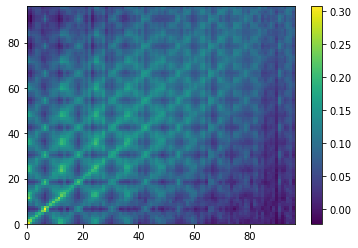

In [145]:
plt.figure()
plt.pcolormesh(corner)
plt.colorbar()

In [95]:
feat_filename = os.path.join(default_paths.gabor_texture_feat_path, 'S1_features_each_prf_12ori_8sf_gabor_solo_nonlin_grid5.h5py')

            
             

'/user_data/mmhender/features/gabor_texture'

In [52]:
thing = np.reshape(np.arange(12),[4,3])
thing

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [53]:
thing2 = [-2,2,4]
thing+thing2

array([[-2,  3,  6],
       [ 1,  6,  9],
       [ 4,  9, 12],
       [ 7, 12, 15]])

In [49]:
np.array([[-2,2,4]]).T.shape

(3, 1)